In [16]:
import difflib
import json
import os
import random
import re
import torch

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sentence_transformers import SentenceTransformer, util
from language_classifier.language_classifier import LanguageClassifier

# formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 200)

# import data

In [2]:
# folders
parsed_docs_folder = os.path.join("..", "ParsedPublications")
fr_eng_correlation_csv = "fr_eng_correlation_data.csv"

fr_eng_correlation_df = pd.read_csv(fr_eng_correlation_csv)

# weblinks for previewing / testing
weblinks_df = fr_eng_correlation_df.copy()
weblinks_df = weblinks_df[['pub_number', 'nom', 'name', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

# simplified correlation table
fr_eng_correlation_df = fr_eng_correlation_df[['pub_number', 'filename_fr', 'filename_en']]

# helper functions

In [3]:
def preview_publication(pub_number):
    if type(pub_number) is pd.DataFrame and pub_number.shape[0] == 1:
        try:
            pub_number = pub_number['pub_number'].values[0]
        except ValueError:
            return None
    elif type(pub_number) is pd.Series:
        try:
            pub_number = pub_number.values[0]
        except ValueError:
            return None
    
    try:
        output_df = weblinks_df[weblinks_df.pub_number == pub_number].T
    except Exception as e:
        print(e)
        return None
        
    return output_df


# DATA CLEANING FUNCTIONS

def clean_text(text):

    allowed_chars = r"[^a-zA-ZÀ-ÖØ-öø-ÿ.,;:!?()'\"-]"
    text = re.sub(allowed_chars, ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text


def get_files_for_publication(pub_number, fr_eng_correlation_df):
    row = fr_eng_correlation_df.loc[fr_eng_correlation_df['pub_number'] == pub_number]
    if not row.empty:
        filename_fr = row['filename_fr'].values[0]
        filename_en = row['filename_en'].values[0]
        return filename_fr, filename_en
    return None, None


def get_json_file_link(parsed_docs_folder, pdf_filename):
    if pdf_filename.endswith(".pdf"):
        json_filename = pdf_filename + ".json"
        for root, _, files in os.walk(parsed_docs_folder):
            if json_filename in files:
                return os.path.join(root, json_filename)
    return None


def extract_text_from_single_file(json_file, target_language, clf):
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = clean_text(data['text'])
    text_blocks = re.split(r'(?<![;,])[.?!\n]', full_text)
    text = []

    for block in text_blocks:
        block = block.strip()
        if not block:
            continue
            
        if clf.classify(block) == target_language:
            text.append(block + '.')      

    return " ".join(text)


def extract_both_languages_from_two_files(json_file_fr, json_file_en, clf):
    return extract_text_from_single_file(json_file_fr, "fr", clf), extract_text_from_single_file(json_file_en, "en", clf)


def extract_both_languages_from_single_file(json_file, clf):
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = data['text']
    text_blocks = re.split(r'[.\n?]', full_text)
    text_fr, text_en = [], []

    for block in text_blocks:
        block = block.strip()
        if not block:
            continue
            
        if clf.classify(block) == "fr":
            text_fr.append(block)   
        elif clf.classify(block) == "en":
            text_en.append(block)   

    return " ".join(text_fr), " ".join(text_en)


def correlate_and_clean_text(text_fr, text_en):
    matcher = difflib.SequenceMatcher(None, text_fr.split(), text_en.split())
    matched_fr, matched_en = [], []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            matched_fr.append(" ".join(text_fr.split()[i1:i2]))
            matched_en.append(" ".join(text_en.split()[j1:j2]))
    
    return matched_fr, matched_en


def process_all_rows(fr_eng_correlation_df, parsed_docs_folder, clf):
    debug = True  # TODO: remove after DEBUG
    
    matched_data = []
    min_text_quality = 1
    
    for _, row in fr_eng_correlation_df.iterrows():
        pub_number = row['pub_number']
        filename_fr, filename_en = row['filename_fr'], row['filename_en']
        
        if filename_fr == "WITHDRAWN" and filename_en == "WITHDRAWN":
            continue
        
        fr_link = get_json_file_link(parsed_docs_folder, filename_fr)
        if fr_link == None:
            continue
        
        if filename_fr == filename_en:
            text_fr, text_en = extract_both_languages_from_single_file(fr_link, clf)
        else:
            en_link = get_json_file_link(parsed_docs_folder, filename_en) 
            if en_link == None:
                continue
            text_fr, text_en = extract_both_languages_from_two_files(fr_link, en_link, clf            )
        
        if debug:
            matched_fr, matched_en = text_fr, text_en  # TODO: remove after DEBUG
        else:            
            matched_fr, matched_en = correlate_and_clean_text(text_fr, text_en)  # TODO: confirm
        
        matched_data.append({'pub_number': pub_number, 'text_fr': matched_fr, 'text_en': matched_en})
    
    return pd.DataFrame(matched_data)


In [4]:
clf = LanguageClassifier()

matched_df = process_all_rows(fr_eng_correlation_df, parsed_docs_folder, clf)

In [5]:
# TODO: a better way to do this??? merge from both sides? check for capital letter?

def create_similarity_matrix(text_fr, text_en):
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

    sentences_fr = [x.strip() for x in text_fr.split(".") if x != ""]
    sentences_en = [x.strip() for x in text_en.split(".") if x != ""]
    
    embeddings_fr = model.encode(sentences_fr, convert_to_tensor=True)
    embeddings_en = model.encode(sentences_en, convert_to_tensor=True)

    return util.pytorch_cos_sim(embeddings_fr, embeddings_en)


row_n = 1000
text_fr, text_en = matched_df.iloc[row_n]['text_fr'], matched_df.iloc[row_n]['text_en']
similarity_matrix = create_similarity_matrix(text_fr, text_en)

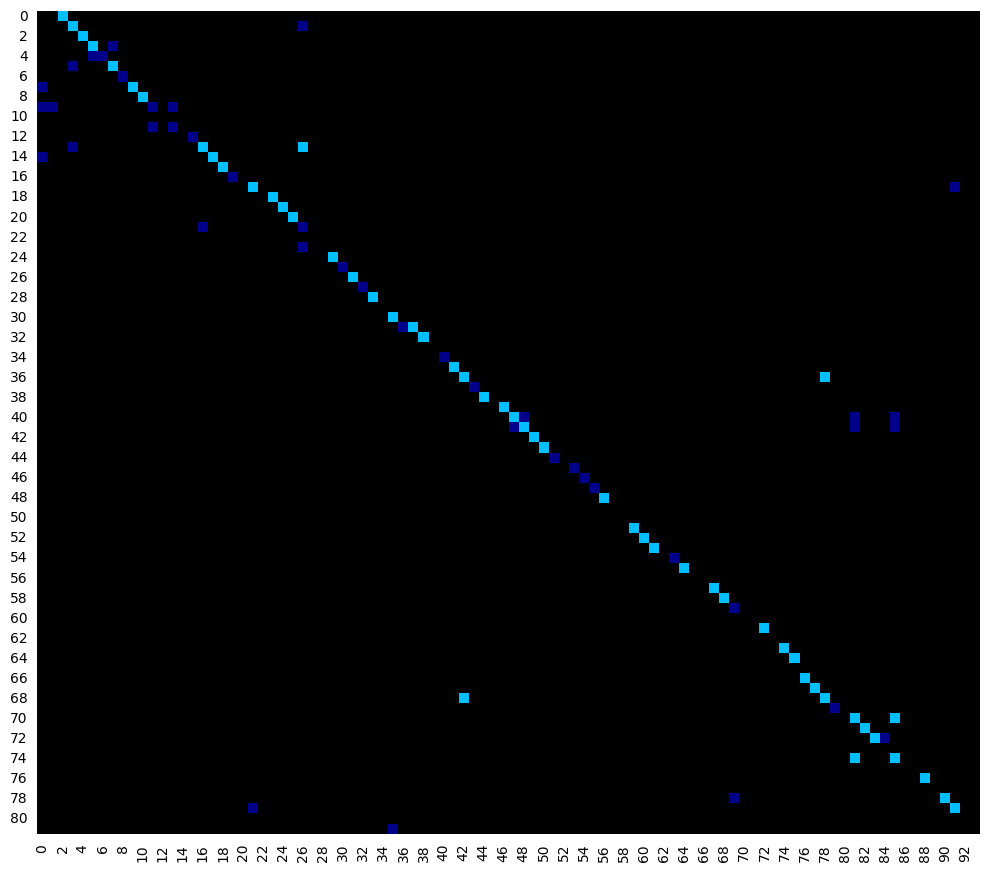

In [23]:
def plot_similarity_heatmap(similarity_matrix):
    fig, ax = plt.subplots(figsize=(10, 10)) 
    
    cmap = mcolors.ListedColormap(["black", "darkblue", "deepskyblue"])
    bounds = [0, 0.7, 0.8, 1]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, square=True, linewidths=0, ax=ax)

    ax.tick_params(left=False, bottom=False)

    plt.tight_layout()
    plt.show()


plot_similarity_heatmap(similarity_matrix)

In [5]:
# TODO: traverse matrix like tree or A*
#  skip bad matches
#  merge everything between good matches and recheck for match




In [6]:
def merge_short_sentences(sentences, min_length=10):
    merged_sentences = []
    buffer = ""

    for sentence in sentences:
        if len(sentence) < min_length:
            buffer += " " + sentence
        else:
            if buffer:
                merged_sentences.append(buffer.strip() + " " + sentence)
                buffer = ""
            else:
                merged_sentences.append(sentence)

    if buffer:
        merged_sentences.append(buffer.strip())

    return merged_sentences


def correlate_and_clean_text(text_fr, text_en):
    # TODO: can this be force into order, go through en / fr at the same time, merging as required
    
    min_score = 0.7
    
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

    sentences_fr = [x.strip() for x in text_fr.split(".") if x != ""]
    sentences_en = [x.strip() for x in text_en.split(".") if x != ""]
    
    # TODO: merge short sentences

    embeddings_fr = model.encode(sentences_fr, convert_to_tensor=True)
    embeddings_en = model.encode(sentences_en, convert_to_tensor=True)

    similarity_matrix = util.pytorch_cos_sim(embeddings_fr, embeddings_en)

    matched_fr, matched_en = [], []
    used_en_indices = set()

    for i, emb_fr in enumerate(embeddings_fr):
        scores = similarity_matrix[i]
        best_match_idx = scores.argmax().item()
        
        if scores[best_match_idx] > min_score and best_match_idx not in used_en_indices:
            matched_fr.append(sentences_fr[i])
            matched_en.append(sentences_en[best_match_idx])
            used_en_indices.add(best_match_idx)

    return matched_fr, matched_en



In [7]:
row_n = 1000
text_fr, text_en = matched_df.iloc[row_n]['text_fr'], matched_df.iloc[row_n]['text_en']

correlate_and_clean_text(text_fr, text_en)

matched_fr, matched_en = correlate_and_clean_text(text_fr, text_en)

for fr, en in zip(matched_fr, matched_en):
    print(f"FR: {fr}\nEN: {en}\n")

FR: Mont-Joli, Québec, G H Z Avant-propos Le présent compte rendu a pour but de consigner les principales activités et discussions qui ont eu lieu au cours de la réunion
EN: Box Mont-Joli, Quebec G H Z Foreword The purpose of these Proceedings is to document the activities and key discussions of the meeting

FR: Il peut contenir des recommandations sur les recherches à effectuer, les incertitudes et les justifications des décisions prises pendant la réunion
EN: The Proceedings may include research recommendations, uncertainties, and the rationale for decisions made during the meeting

FR: Le compte rendu peut aussi faire l état de données, d analyses ou d interprétations passées en revue et rejetées pour des raisons scientifiques, en donnant la raison du rejet
EN: Proceedings may also document when data, analyses or interpretations were reviewed and rejected on scientific grounds, including the reason(s) for rejection

FR: Bien que les interprétations et les opinions contenues dans le 

In [8]:
n_min = 30
sentences_fr = [x.strip() for x in text_fr.split(".") if x != ""]
sentences_en = [x.strip() for x in text_en.split(".") if x != ""]
len(sentences_fr), len(merge_short_sentences(sentences_fr, n_min))

(82, 81)

In [9]:
[x for x in sentences_en if x not in merge_short_sentences(sentences_en, n_min)]

['Purchase prices vary by size',
 'This appears to provide an incentive to target certain sizes, and therefore certain fishing grounds',
 'would be closer to reality',
 'Some participants believe that sampling was insufficient']

In [10]:
[x for x in merge_short_sentences(sentences_en, n_min) if x not in sentences_en]

['Purchase prices vary by size This appears to provide an incentive to target certain sizes, and therefore certain fishing grounds',
 'would be closer to reality Some participants believe that sampling was insufficient']